# Dependencies

In [1]:
import pandas as pd

# Load the Data

In [2]:
fremont_bridge = 'https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD'

bicycle_weather = 'https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv'

counts = pd.read_csv(fremont_bridge, index_col='Date', parse_dates=True, 
                     infer_datetime_format=True)

weather = pd.read_csv(bicycle_weather, index_col='DATE', parse_dates=True, 
                      infer_datetime_format=True)

daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns

weather_columns = ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND']
daily = daily.join(weather[weather_columns], how='inner')

# Make a feature for yesterday's total
daily['Total_yesterday'] = daily.Total.shift(1)
daily = daily.drop(index=daily.index[0])

daily.head()

,Total,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday
2012-10-04,3475.0,0,0,0,189,83,65,3521.0
2012-10-05,3148.0,0,0,0,217,89,57,3475.0
2012-10-06,2006.0,0,0,0,239,78,51,3148.0
2012-10-07,2142.0,0,0,0,239,78,13,2006.0
2012-10-08,3537.0,0,0,0,211,78,19,2142.0


# Create Test/Train Sets

In [3]:
X_train = daily.drop(columns='Total')[:-100]
X_test = daily.drop(columns='Total')[-100:]

y_train = daily['Total'][:-100]
y_test = daily['Total'][-100:]

In [4]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((963, 7), (100, 7), (963,), (100,))

# Detect & Replace Incorrect  Data

In [5]:
daily.describe()

,Total,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday
count,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000
mean,2632.449671,29.350894,-37.496707,0.098777,166.863594,84.472248,22.338664,2633.056444
std,1252.864020,65.813053,612.512583,2.570041,74.779734,50.916006,307.984292,1253.138245
min,98.000000,0.000000,-9999.000000,0.000000,-16.000000,-71.000000,-9999.000000,98.000000
25%,1806.000000,0.000000,0.000000,0.000000,111.000000,44.000000,22.000000,1806.000000
50%,2435.000000,0.000000,0.000000,0.000000,150.000000,83.000000,29.000000,2435.000000
75%,3574.500000,26.500000,0.000000,0.000000,222.000000,128.000000,40.000000,3574.500000
max,6088.000000,559.000000,74.000000,80.000000,356.000000,183.000000,95.000000,6088.000000


In [6]:
def clean(X):
    AWND_mean = X_train['AWND'].mean()
    SNOW_mean = X_train['SNOW'].mean()

    X['AWND'] = X['AWND'].replace({-9999:AWND_mean})
    X['SNOW'] = X['SNOW'].replace({-9999:SNOW_mean})
    
    return X

In [7]:
X_train = clean(X_train)
X_test = clean(X_test)

# Create Features

In [8]:
import numpy as np

In [9]:
def make_features(X):
    X = X.copy()

    # patterns of use generally vary from day to day; 
    # let's add binary columns that indicate the day of the week:
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    for i, day in enumerate(days):
        X[day] = (X.index.dayofweek == i).astype(float)


    # we might expect riders to behave differently on holidays; 
    # let's add an indicator of this as well:
    from pandas.tseries.holiday import USFederalHolidayCalendar
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays('2012', '2016')
    X = X.join(pd.Series(1, index=holidays, name='holiday'))
    X['holiday'].fillna(0, inplace=True)
    
    # We also might suspect that the hours of daylight would affect 
    # how many people ride; let's use the standard astronomical calculation 
    # to add this information:
    def hours_of_daylight(date, axis=23.44, latitude=47.61):
        """Compute the hours of daylight for the given date"""
        days = (date - pd.datetime(2000, 12, 21)).days
        m = (1. - np.tan(np.radians(latitude))
             * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
        return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

    X['daylight_hrs'] = list(map(hours_of_daylight, X.index))
    
    # temperatures are in 1/10 deg C; convert to C
    X['TMIN'] /= 10
    X['TMAX'] /= 10
    
    # We can also calcuate the average temperature.
    X['Temp (C)'] = 0.5 * (X['TMIN'] + X['TMAX'])
    
    # Convert Temperatures to Farenheit
    X['TMIN'] = X['TMIN'] * 1.8 + 32
    X['TMAX'] = X['TMAX'] * 1.8 + 32
    X['Temp (C)'] = X['Temp (C)'] * 1.8 + 32
    X = X.rename(columns={'Temp (C)':'Temp (F)'})
    
    # precip is in 1/10 mm; convert to inches
    X['PRCP'] /= 254

    # In addition to the inches of precipitation, let's add a flag that 
    # indicates whether a day is dry (has zero precipitation):
    X['dry day'] = (X['PRCP'] == 0).astype(int)

    # Let's add a counter that increases from day 1, and measures how many 
    # years have passed. This will let us measure any observed annual increase 
    # or decrease in daily crossings:
    X['annual'] = (X.index - X.index[0]).days / 365.
    
    # Create feature to indicate how many standardeviations from the mean the data is 
    temp_mean = X['Temp (F)'].mean()
    temp_std = X['Temp (F)'].std()
    X['Temp_STD_from_mean'] = abs(X['Temp (F)'] - temp_mean) / temp_std
    
    # Create feature that record's the temperate from yesterday
    X['Yesterdays Temp'] = X.tshift(periods=1)['Temp (F)'] 
    X['Yesterdays Temp'] = X['Yesterdays Temp'].fillna(method='bfill')
    
    # Create feature that records the total number of crossings from a week ago
    X['Total_yesterday'] = X.shift(periods=7)['Total_yesterday']
    X['Total_yesterday'] = X['Total_yesterday'].fillna(method='bfill')
    
    return X

In [10]:
X_train = make_features(X_train)
X_test = make_features(X_test)

In [109]:
X_train.shape, X_test.shape

((963, 20), (100, 21))

# Preprocessing

# XGBoost Modeling

In [19]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV

In [20]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [114]:
from xgboost import XGBRegressor

build_boost = Pipeline(steps=[
       ('model', XGBRegressor(n_jobs=-1))
])

param_grid = {
    'model__n_estimators':[100, 250, 500],
    'model__learning_rate':[.03, .05, .07, .09],
    'model__max_depth':[1, 3, 5]
}

In [115]:
search = GridSearchCV(build_boost, 
                      param_grid=param_grid, 
                      return_train_score=True, 
                      scoring='neg_mean_absolute_error', 
                      cv=3,
                      verbose=10,
                      n_jobs=-1)
search.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   12.3s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('model', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'model__n_estimators': [100, 250, 500], 'model__learning_rate': [0.03, 0.05, 0.07, 0.09], 'model__max_depth': [1, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=10)

In [116]:
best = search.best_estimator_
print('Best Score:', search.best_score_)
print('Best Params:', search.best_params_)

Best Score: -313.24819791007513
Best Params: {'model__learning_rate': 0.07, 'model__max_depth': 5, 'model__n_estimators': 500}


# Feature Importances

In [31]:
best = best.steps[0][1]

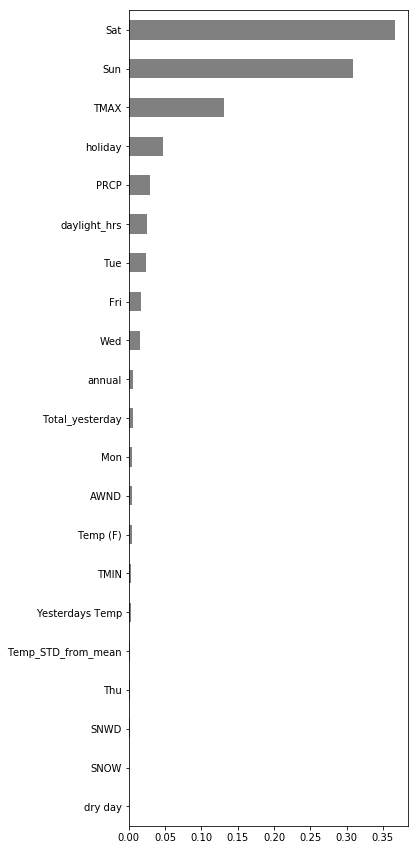

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,15))

importances = pd.Series(best.feature_importances_, X_train.columns)
top = importances.sort_values()

top.plot.barh(color='gray');

## Permutation Importance

In [54]:
X_test_permuted = X_test.copy()
X_test_permuted['Sat'] = np.random.permutation(X_test_permuted['Sat'])

In [55]:
from sklearn.metrics import mean_absolute_error

y_pred = best.predict(X_test)
print('Test Accuracy Score with \'Sat\':', mean_absolute_error(y_test, y_pred) )

y_pred = best.predict(X_test_permuted)
print('Test Accuracy Score without \'Sat\':', mean_absolute_error(y_test, y_pred))

Train Accuracy Score with 'Sat': 282.2089196777344
Train Accuracy Score without 'Sat': 651.790658569336


# Permutation Importance

In [61]:
X_train.values

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 3.21047464e-01, 5.64800000e+01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.73972603e-03, 6.16379020e-01, 5.64800000e+01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.47945205e-03, 7.11927465e-01, 5.95400000e+01],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.63013699e+00, 4.25282131e-01, 6.55700000e+01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.63287671e+00, 3.73164797e-01, 5.75600000e+01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.63561644e+00, 4.68713242e-01, 5.70200000e+01]])

In [67]:
import eli5 
from eli5.sklearn import PermutationImportance

# The model also needs to fit with the nd.array data type
## https://www.kaggle.com/dansbecker/permutation-importance#392299
best.fit(X_train.values, y_train)

permuter = PermutationImportance(best,
                                scoring='neg_mean_absolute_error',
                                cv='prefit',
                                n_iter=2, 
                                random_state=42)
permuter.fit(X_train.values, y_train)

/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


PermutationImportance(cv='prefit',
           estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.07, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=500, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
           n_iter=2, random_state=42, refit=True,
           scoring='neg_mean_absolute_error')

In [69]:
feature_names = X_train.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
559.3388 ± 32.6985,TMAX
316.4909 ± 14.4874,Sun
309.8035 ± 9.4121,Sat
300.2453 ± 8.7792,daylight_hrs
290.5648 ± 21.0886,PRCP
124.9916 ± 2.2757,annual
99.1053 ± 5.5853,TMIN
87.2689 ± 3.2599,Total_yesterday
70.8517 ± 3.0753,AWND
65.0376 ± 2.5758,Yesterdays Temp


In [70]:
X_train.shape

(963, 21)

In [72]:
mask = permuter.feature_importances_ > 0
features = X_train.columns[mask]
X_train = X_train[features]
X_train.shape

(963, 20)

In [73]:
search = GridSearchCV(build_boost, 
                      param_grid=param_grid, 
                      return_train_score=True, 
                      scoring='neg_mean_absolute_error', 
                      cv=3,
                      verbose=10,
                      n_jobs=-1)

search.fit(X_train, y_train)

best = search.best_estimator_
print('Best Score:', search.best_score_)
print('Best Params:', search.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   51.4s finished
/anaconda3/lib/python3.6/site-packages/xgboost/

Best Score: -313.24819791007513
Best Params: {'model__learning_rate': 0.07, 'model__max_depth': 5, 'model__n_estimators': 500}


In [79]:
best = (search.best_estimator_).steps[0][1]
best

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.07, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=500, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

# Partial Dependence Plots 

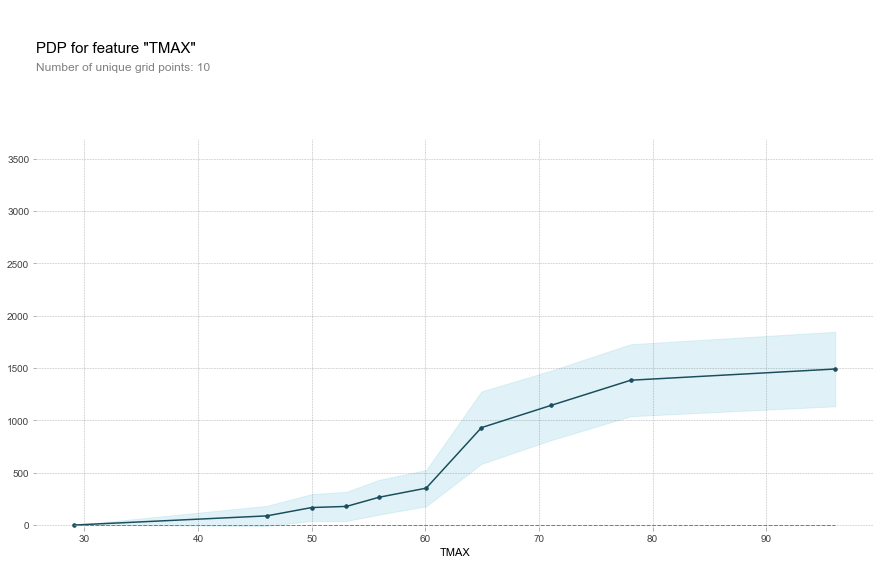

In [84]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'TMAX'

isolated = pdp_isolate(
    model = best,
    dataset = X_train, 
    model_features=X_train.columns,
    feature = feature
)

pdp_plot(isolated, feature_name=feature);

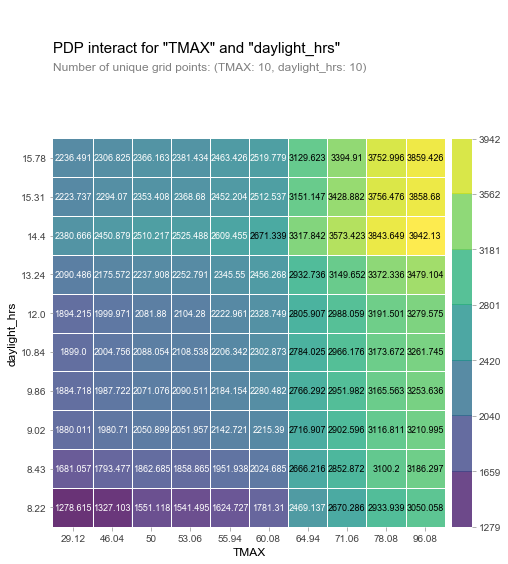

In [85]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['TMAX', 'daylight_hrs']

interaction = pdp_interact(
    model=best,
    dataset=X_train,
    model_features=X_train.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);


# Shaply Values

In [89]:
best.fit(X_train.values, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.07, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=500, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [100]:
import shap

shap.initjs()
data_for_predict = X_train.iloc[5,:]
explainer = shap.TreeExplainer(best)
shap_values = explainer.shap_values(data_for_predict)

shap.force_plot(explainer.expected_value, shap_values, data_for_predict)

In [103]:
shap.initjs()
data_for_predict = X_train.iloc[100, :]
explainer = shap.TreeExplainer(best)
shap_values = explainer.shap_values(data_for_predict)

shap.force_plot(explainer.expected_value, shap_values, data_for_predict)